In [84]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib as plt
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric

In [4]:
bitcoin = pd.read_csv("../data/bitcoin.csv")

In [5]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Fecha     4437 non-null   object
 1   Último    4437 non-null   object
 2   Apertura  4437 non-null   object
 3   Máximo    4437 non-null   object
 4   Mínimo    4437 non-null   object
 5   Vol.      4437 non-null   object
 6   % var.    4437 non-null   object
dtypes: object(7)
memory usage: 242.8+ KB


In [6]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [7]:
bitcoin.head()

Fecha    Último  Apertura    Máximo    Mínimo     Vol.  % var.
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

We can see that "Fecha" is in descending order, so we need to change that

In [8]:
bitcoin.describe()

Fecha Último Apertura Máximo Mínimo   Vol. % var.
count         4437   4437     4437   4437   4437   4437   4437
unique        4437   3485     3478   3470   3480   3965   1515
top     09.09.2022    0,1      0,1    0,1    0,1  1,05M  0,00%
freq             1    100      100     97    101      6    425

In [9]:
fig = px.line(bitcoin, x="Fecha", y="Máximo")
fig.show()

In this plot (which it shows the fluctuation of Bitcoin price in a strange way, due to the column "Fecha" being in descending order) see that a great amount of values don't show much change for a long period of time. We're not interested in those values because they can only tell us that Bitcoin wasn´'t what it is now. We'll get rid of them later, after cleaning the data.



In [10]:
bitcoin.columns = ["date", "last", "open", "high", "low", "vol", "var_%"]

In [11]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0  09.09.2022  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  08.09.2022  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  07.09.2022  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  06.09.2022  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  05.09.2022  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [12]:
bitcoin["date"].describe()

count           4437
unique          4437
top       09.09.2022
freq               1
Name: date, dtype: object

In [13]:
bitcoin["date"]= pd.to_datetime(bitcoin["date"], dayfirst=True)

In [14]:
bitcoin.head()

date      last      open      high       low      vol   var_%
0 2022-09-09  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1 2022-09-08  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2 2022-09-07  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3 2022-09-06  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4 2022-09-05  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In [15]:
bitcoin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4437 entries, 0 to 4436
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4437 non-null   datetime64[ns]
 1   last    4437 non-null   object        
 2   open    4437 non-null   object        
 3   high    4437 non-null   object        
 4   low     4437 non-null   object        
 5   vol     4437 non-null   object        
 6   var_%   4437 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 242.8+ KB


In [16]:
num = bitcoin.drop("date", axis = 1)

In [17]:
num.head()

last      open      high       low      vol   var_%
0  20.742,8  19.318,8  20.743,7  19.294,1  359,40K   7,38%
1  19.317,4  19.281,5  19.444,7  19.034,5  291,43K   0,19%
2  19.281,5  18.786,3  19.445,9  18.548,4  319,10K   2,64%
3  18.786,4  19.793,4  20.169,3  18.723,3  402,43K  -5,09%
4  19.793,1  19.999,9  20.042,9  19.650,7  238,71K  -1,03%

In the cell below we replace the letters and symbols that we don't want

In [18]:
for i in num:
    for j in range(len(num)):
        num[i][j] = num[i][j].replace(".", "")
        num[i][j] = num[i][j].replace(",", ".")
        if "%" in num[i][j]:
            num[i][j] = num[i][j].replace("%", "")
        elif "K" in num[i][j]:
            num[i][j] = float(num[i][j].replace("K", ""))
        elif "M" in num[i][j]:
            num[i][j] = float(num[i][j].replace("M", "")) * 1000
            if num[i][j] > 15:
                num[i][j] = num[i][j] / 1000
        elif "B" in num[i][j]:
            num[i][j] = float(num[i][j].replace("B", "")) * 1000
        elif num[i][j] == "-":
            num[i][j] = 0
        else:
            pass

In [19]:
num.head()

last     open     high      low     vol  var_%
0  20742.8  19318.8  20743.7  19294.1   359.4   7.38
1  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2  19281.5  18786.3  19445.9  18548.4   319.1   2.64
3  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
4  19793.1  19999.9  20042.9  19650.7  238.71  -1.03

In [20]:
num = num.astype(float)

In [21]:
bitcoin[["last", "open", "high", "low", "vol", "var_%"]] = num

Now we sort the dates in descending order and take out the useless values

In [22]:
bitcoin = bitcoin.sort_values(by='date').reset_index(drop = True)

In [23]:
bitcoin = bitcoin[bitcoin["date"] >= "2012-01-01"]

In [24]:
bitcoin = bitcoin.set_index("date")

In [25]:
bitcoin.insert(loc = 0, column = "date", value = bitcoin.index)

In [26]:
bitcoin

date     last     open     high      low     vol  var_%
date                                                                    
2012-01-01 2012-01-01      5.3      4.7      5.5      4.6  108.51  11.65
2012-01-02 2012-01-02      5.2      5.3      5.5      4.8   69.15  -0.95
2012-01-03 2012-01-03      4.9      5.2      5.3      4.7  125.17  -6.51
2012-01-04 2012-01-04      5.6      4.9      5.7      4.8  131.17  14.14
2012-01-05 2012-01-05      6.9      5.6      7.2      5.6  182.33  24.78
...               ...      ...      ...      ...      ...     ...    ...
2022-09-05 2022-09-05  19793.1  19999.9  20042.9  19650.7  238.71  -1.03
2022-09-06 2022-09-06  18786.4  19793.4  20169.3  18723.3  402.43  -5.09
2022-09-07 2022-09-07  19281.5  18786.3  19445.9  18548.4  319.10   2.64
2022-09-08 2022-09-08  19317.4  19281.5  19444.7  19034.5  291.43   0.19
2022-09-09 2022-09-09  20742.8  19318.8  20743.7  19294.1  359.40   7.38

[3905 rows x 7 columns]

Now we have the data cleaned and date column in correct order. 
Next thing is to check if the dates follows the same frequency.

In [27]:
bit_2 = bitcoin.copy()

bit_2['date_shift'] = bit_2['date'].shift()  

In [28]:
bit_2.head()

date  last  open  high  low     vol  var_% date_shift
date                                                                  
2012-01-01 2012-01-01   5.3   4.7   5.5  4.6  108.51  11.65        NaT
2012-01-02 2012-01-02   5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01
2012-01-03 2012-01-03   4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02
2012-01-04 2012-01-04   5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03
2012-01-05 2012-01-05   6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04

In [29]:
bit_2['diff'] = bit_2['date'] - bit_2['date_shift']

In [30]:
bit_2.head()

date  last  open  high  low     vol  var_% date_shift   diff
date                                                                         
2012-01-01 2012-01-01   5.3   4.7   5.5  4.6  108.51  11.65        NaT    NaT
2012-01-02 2012-01-02   5.2   5.3   5.5  4.8   69.15  -0.95 2012-01-01 1 days
2012-01-03 2012-01-03   4.9   5.2   5.3  4.7  125.17  -6.51 2012-01-02 1 days
2012-01-04 2012-01-04   5.6   4.9   5.7  4.8  131.17  14.14 2012-01-03 1 days
2012-01-05 2012-01-05   6.9   5.6   7.2  5.6  182.33  24.78 2012-01-04 1 days

In [31]:
bit_2[bit_2['diff'] != '1 days'].index 

DatetimeIndex(['2012-01-01'], dtype='datetime64[ns]', name='date', freq=None)

We see there are no values with a "diff" different from 1 "days", so we can say all values are following a daily frequency.
The [0] mis expected, since there is no value previous to the first one. 

We plot again tha data to see how it has changed.

In [32]:
fig = px.line(bitcoin, x="date", y="last")
fig.show()

There are many differences from the first one, but still, there is a big tail at the beginning that we don't need

In [33]:
bitcoin = (bitcoin[bitcoin["date"] >= "2017-01-01"])
bitcoin.head()

date    last    open    high     low     vol  var_%
date                                                                
2017-01-01 2017-01-01   995.4   963.4  1001.6   956.1   41.15   3.33
2017-01-02 2017-01-02  1017.0   995.4  1031.7   990.2   64.95   2.17
2017-01-03 2017-01-03  1033.3  1017.0  1035.5  1006.5   54.79   1.60
2017-01-04 2017-01-04  1135.4  1033.3  1148.5  1022.3  156.27   9.88
2017-01-05 2017-01-05   989.3  1135.4  1150.6   874.5  240.01 -12.86

In [34]:
fig = px.line(bitcoin, x="date", y="last")
fig.show()

Now it's better

In [35]:
bitcoin_17 = bitcoin[bitcoin["date"] < "2018-01-01"]
bitcoin_18 = bitcoin[(bitcoin["date"] > "2018-01-01") & (bitcoin["date"] < "2019-01-01")]
bitcoin_19 = bitcoin[(bitcoin["date"] > "2019-01-01") & (bitcoin["date"] < "2020-01-01")]
bitcoin_20 = bitcoin[(bitcoin["date"] > "2020-01-01") & (bitcoin["date"] < "2021-01-01")]
bitcoin_21 = bitcoin[(bitcoin["date"] > "2021-01-01") & (bitcoin["date"] < "2022-01-01")]
bitcoin_22 = bitcoin[(bitcoin["date"] > "2022-01-01")]

<Figure size 2400x1200 with 0 Axes>

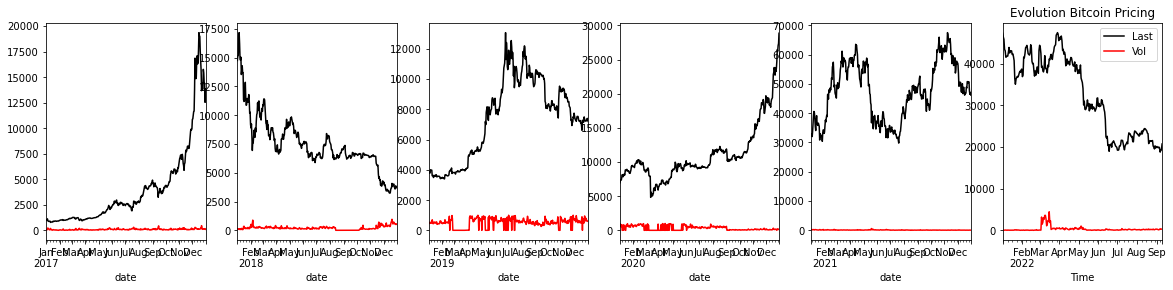

<Figure size 2400x1200 with 0 Axes>

In [36]:
fig, axes = plt.subplots(1, 6, figsize=(20,4))



bitcoin_17['last'].plot(label='Last', color='black', ax = axes[0])
bitcoin_17['vol'].plot(label='Vol', color = "red", ax = axes[0])

bitcoin_18['last'].plot(label='Last', color='black', ax = axes[1])
bitcoin_18['vol'].plot(label='Vol', color = "red", ax = axes[1]) 

bitcoin_19['last'].plot(label='Last', color='black', ax = axes[2])
bitcoin_19['vol'].plot(label='Vol', color = "red", ax = axes[2])

bitcoin_20['last'].plot(label='Last', color='black', ax = axes[3])
bitcoin_20['vol'].plot(label='Vol', color = "red", ax = axes[3])

bitcoin_21['last'].plot(label='Last', color='black', ax = axes[4])
bitcoin_21['vol'].plot(label='Vol', color = "red", ax = axes[4])

bitcoin_22['last'].plot(label='Last', color='black', ax = axes[5])
bitcoin_22['vol'].plot(label='Vol', color = "red", ax = axes[5])
plt.title('Evolution Bitcoin Pricing')
  
plt.xlabel("Time")
  
plt.legend()

plt.figure(figsize=(16, 8), dpi=150)



In [37]:
bitcoin.shape

(2078, 7)

In [38]:
bitcoin.to_csv('../data/clean_data.csv')

We are going to use the values from column "last" to predict the future results.

In [39]:
bitcoin_last = bitcoin[["last"]]

In [40]:
bitcoin_last.head()

last
date              
2017-01-01   995.4
2017-01-02  1017.0
2017-01-03  1033.3
2017-01-04  1135.4
2017-01-05   989.3

#### STATIONARITY

In [41]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags = "auto") 
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [42]:
adf_test(bitcoin_last["last"])

Results of Dickey-Fuller Test:
Test Statistic                   -1.510124
p-value                           0.528497
#Lags Used                       24.000000
Number of Observations Used    2053.000000
Critical Value (1%)              -3.433539
Critical Value (5%)              -2.862949
Critical Value (10%)             -2.567520
dtype: float64


From adf_test we see there is no stationarity. The p-value returned is higher than the significance level o.o5, and Test Statistic is also higher than the Critical Value 2.86. Therefore we accept the null hypothesis: TS has no Stationarity

In [43]:
kpss_test(bitcoin_last["last"])

Results of KPSS Test:
Test Statistic            4.678438
p-value                   0.010000
Lags Used                28.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




For the kpss_test we see p-value lower than significance level 0.05. But a higher Test Statistic: 4.68 than Critical Value: 0.46.
Being the H0: TS Stationarity

#### ACF PACF

In the cell below we check for ACF and PACF; autocorrelation and partial autocorrelation.

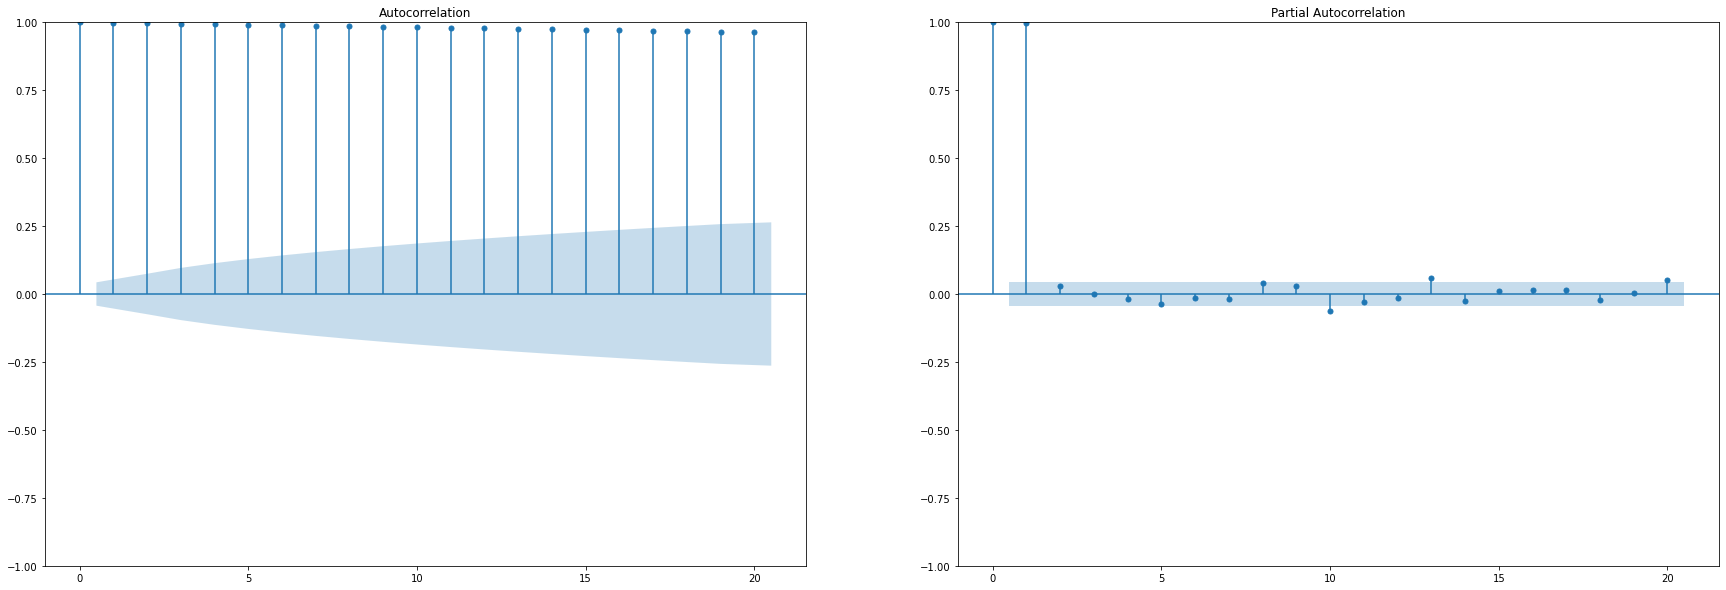

In [44]:
fig, axes = plt.subplots(1, 2, figsize= (30, 10))

fig = sm.graphics.tsa.plot_acf(bitcoin_last['last'],
                               lags = 20,                               
                               ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(bitcoin_last['last'], lags = 20, 
                                ax=axes[1], method = "ywm")

By looking at the plots we see a high Autocorrelation, meaning that each values is highly correlated to the previous one. 

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

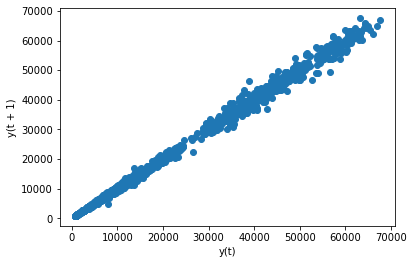

In [45]:
pd.plotting.lag_plot(bitcoin_last["last"])

On the plot above we can almost see a straight line. This tells us that the previous value can be used to predict the next one, to do so, AR(1) model is the one to use

#### ARIMA model

In [46]:
import math 

max_train = math.ceil(len(bitcoin_last) * 0.80) # We want to use the first 80% of the TS records for training. 
max_train

1663

In [47]:
train = bitcoin_last.iloc[:max_train,:]['last']
test  = bitcoin_last.iloc[max_train:,:]['last']

In [48]:
from statsmodels.tsa.arima.model import ARIMA
ARIMA_model1 = ARIMA(bitcoin_last["last"], order = (1, 2, 2))
ARIMA_fit_1 = ARIMA_model1.fit()
ARIMA_fit_1.summary()

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\guill\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   last   No. Observations:                 2078
Model:                 ARIMA(1, 2, 2)   Log Likelihood              -17197.750
Date:                Mon, 12 Sep 2022   AIC                          34403.500
Time:                        16:23:38   BIC                          34426.053
Sample:                    01-01-2017   HQIC                         34411.765
                         - 09-09-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9999      1.776     -0.563      0.573      -4.481       2.481
ma.L1      -6.785e-05      1.775  -3.82e-05      1.000      -3.479       3.479
ma.L2         -0.9999      1.775     -0.563      0.573      -4.479       2.479
sigma2      9.179e+05   2.65e-08   3.46e+13      0.000    9.18e+05    9.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.39   Jarque-Bera (JB):             10770.61
Prob(Q):                              0.12   Prob(JB):                         0.00
Heteroskedasticity (H):              16.39   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.65e+29. Standard errors may be unstable.
"""

C:\Users\guill\AppData\Local\Temp\ipykernel_25284\1883856854.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



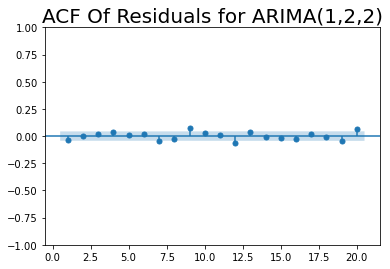

In [49]:
bitcoin_last["res_ARIMA_1"] = ARIMA_fit_1.resid
sgt.plot_acf(bitcoin_last["res_ARIMA_1"], zero = False, lags = 20)
plt.title("ACF Of Residuals for ARIMA(1,2,2)", size = 20)
plt.show()

In [50]:
ARIMA_predictions_1 = ARIMA_fit_1.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)


In [51]:
bitcoin_last["ARIMA_predictions_1"] = ARIMA_predictions_1

C:\Users\guill\AppData\Local\Temp\ipykernel_25284\990456338.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='date'>

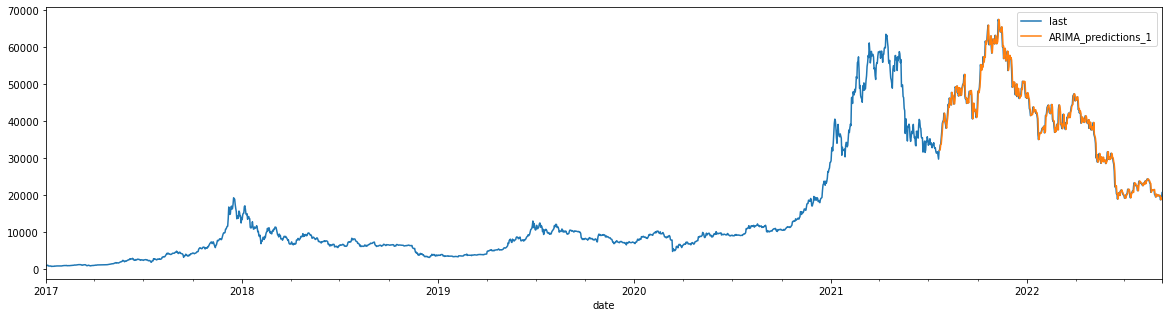

In [52]:
bitcoin_last[["last", "ARIMA_predictions_1"]].plot(figsize=(20, 5))

In [53]:
import datetime
from dateutil.relativedelta import relativedelta

start = datetime.datetime.strptime("2022-09-10", "%Y-%m-%d")
date_list = [start + relativedelta(days = x) for x in range(0,12)]
future_prediction = pd.DataFrame(index = date_list, columns= bitcoin_last.columns)
bitcoin_last_pred = pd.concat([bitcoin_last, future_prediction])

In [54]:
bitcoin_last_pred

last  res_ARIMA_1  ARIMA_predictions_1
2017-01-01   995.4   995.400000                  NaN
2017-01-02  1017.0  -476.100915                  NaN
2017-01-03  1033.3  -238.143022                  NaN
2017-01-04  1135.4   -71.815552                  NaN
2017-01-05   989.3  -301.865569                  NaN
...            ...          ...                  ...
2022-09-17     NaN          NaN                  NaN
2022-09-18     NaN          NaN                  NaN
2022-09-19     NaN          NaN                  NaN
2022-09-20     NaN          NaN                  NaN
2022-09-21     NaN          NaN                  NaN

[2090 rows x 3 columns]

In [55]:
len(bitcoin_last)

2078

In [56]:
bitcoin_last_pred["future_prediction"] = ARIMA_fit_1.predict(start  = 2078, end = 2090, dynamic=True)

In [57]:
bitcoin_last_pred[["last","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [58]:
bitcoin_last_pred_22 = bitcoin_last_pred[2020:]

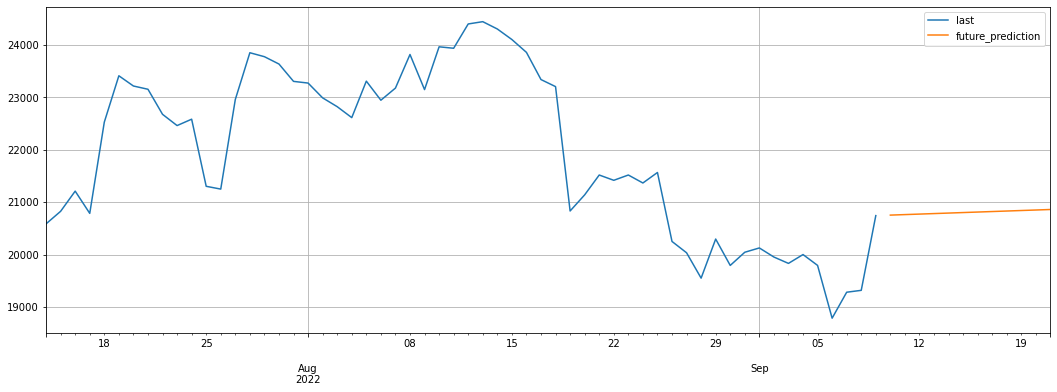

In [59]:
bitcoin_last_pred_22[["last","future_prediction"]].plot(figsize=(18, 6))
plt.grid(True)

In [60]:
bitcoin_last_pred.tail(30)

last  res_ARIMA_1  ARIMA_predictions_1  future_prediction
2022-08-23  21517.2    90.841340         21426.358660                NaN
2022-08-24  21365.2  -162.274568         21527.474568                NaN
2022-08-25  21565.4   190.176438         21375.223562                NaN
2022-08-26  20249.9 -1325.788722         21575.688722                NaN
2022-08-27  20033.9  -225.470487         20259.370487                NaN
2022-08-28  19550.2  -493.239285         20043.439285                NaN
2022-08-29  20295.8   736.477951         19559.322049                NaN
2022-08-30  19792.6  -512.859205         20305.459205                NaN
2022-08-31  20043.9   242.072038         19801.827962                NaN
2022-09-01  20126.1    72.670355         20053.429645                NaN
2022-09-02  19952.7  -182.779757         20135.479757                NaN
2022-09-03  19831.4  -130.775989         19962.175989                NaN
2022-09-04  19999.9   159.271505         19840.628495                NaN
2022-09-05  19793.1  -216.290250         20009.390250                NaN
2022-09-06  18786.4 -1015.900328         19802.300328                NaN
2022-09-07  19281.5   486.205193         18795.294807                NaN
2022-09-08  19317.4    26.952158         19290.447842                NaN
2022-09-09  20742.8  1416.258905         19326.541095                NaN
2022-09-10      NaN          NaN                  NaN       20752.445071
2022-09-11      NaN          NaN                  NaN       20762.264991
2022-09-12      NaN          NaN                  NaN       20771.910074
2022-09-13      NaN          NaN                  NaN       20781.729982
2022-09-14      NaN          NaN                  NaN       20791.375077
2022-09-15      NaN          NaN                  NaN       20801.194972
2022-09-16      NaN          NaN                  NaN       20810.840080
2022-09-17      NaN          NaN                  NaN       20820.659963
2022-09-18      NaN          NaN                  NaN       20830.305083
2022-09-19      NaN          NaN                  NaN       20840.124954
2022-09-20      NaN          NaN                  NaN       20849.770087
2022-09-21      NaN          NaN                  NaN       20859.589945

## PROPHET 

In [65]:
bitcoin_last_prophet = bitcoin[["last", "date"]].rename(columns = {"last": 'y', "date": "ds"})

In [66]:
bitcoin_last_prophet.head()

y         ds
date                         
2017-01-01   995.4 2017-01-01
2017-01-02  1017.0 2017-01-02
2017-01-03  1033.3 2017-01-03
2017-01-04  1135.4 2017-01-04
2017-01-05   989.3 2017-01-05

In [71]:
bitcoin_fbp = Prophet()
bitcoin_fbp.fit(bitcoin_last_prophet)

cast_time = 365
bitcoin_prophet = bitcoin_fbp.make_future_dataframe(periods = cast_time, freq = "D")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



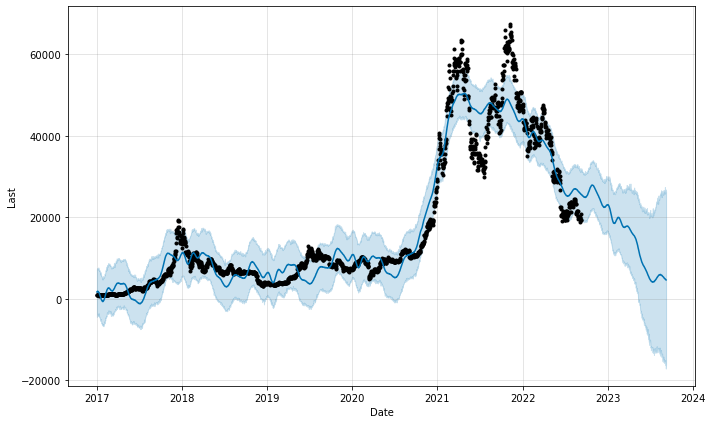

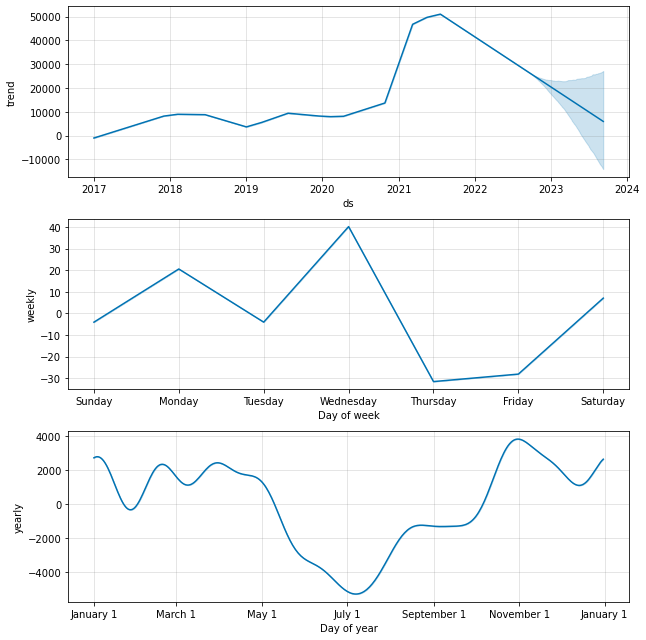

In [72]:
bitcoin_prophet_future = bitcoin_fbp.predict(bitcoin_prophet)

bitcoin_fbp.plot(bitcoin_prophet_future, xlabel = 'Date', ylabel = 'Last')
fig = bitcoin_fbp.plot_components(bitcoin_prophet_future)
plt.show()

In [94]:
fbp_cv = cross_validation(bitcoin_fbp, initial = '1460 days', period = '1 days', horizon = '365 days')
fbp_cv.head()

INFO:prophet:Making 253 forecasts with cutoffs between 2020-12-31 00:00:00 and 2021-09-09 00:00:00


  0%|          | 0/253 [00:00<?, ?it/s]

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\guill\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use

ds          yhat    yhat_lower    yhat_upper        y     cutoff
0 2021-01-01  21119.771464  19558.627603  22674.054735  29359.9 2020-12-31
1 2021-01-02  21106.310392  19553.198241  22682.260027  32193.3 2020-12-31
2 2021-01-03  21031.434294  19546.667610  22732.592491  32958.9 2020-12-31
3 2021-01-04  21019.898267  19313.715192  22470.871931  32022.6 2020-12-31
4 2021-01-05  20955.052805  19517.434848  22597.129282  33991.5 2020-12-31

In [95]:
fig = plot_cross_validation_metric(fbp_cv, metric = 'mape')

In [97]:
bitcoin_prophet_future

ds        trend    yhat_lower    yhat_upper   trend_lower  \
0    2017-01-01 -1032.232101  -4417.160836   7331.143127  -1032.232101   
1    2017-01-02 -1004.609051  -4007.125669   7398.034909  -1004.609051   
2    2017-01-03  -976.986001  -3749.097783   7554.012624   -976.986001   
3    2017-01-04  -949.362951  -4254.460072   7125.220578   -949.362951   
4    2017-01-05  -921.739901  -4015.247783   7451.653957   -921.739901   
...         ...          ...           ...           ...           ...   
2438 2023-09-05  6161.263240 -16189.873452  25995.687161 -13562.480458   
2439 2023-09-06  6103.557169 -15026.150396  26634.351152 -13735.647055   
2440 2023-09-07  6045.851099 -16131.716997  26857.608323 -13862.016044   
2441 2023-09-08  5988.145028 -17124.483452  26139.374247 -13984.217066   
2442 2023-09-09  5930.438958 -16114.376192  26410.732306 -14093.976583   

       trend_upper  additive_terms  additive_terms_lower  \
0     -1032.232101     2706.682087           2706.682087   
1     -1004.609051     2774.002508           2774.002508   
2      -976.986001     2770.593004           2770.593004   
3      -949.362951     2812.975516           2812.975516   
4      -921.739901     2715.631456           2715.631456   
...            ...             ...                   ...   
2438  26896.183390    -1319.616323          -1319.616323   
2439  26963.522786    -1276.774592          -1276.774592   
2440  27030.862183    -1348.746000          -1348.746000   
2441  27091.036729    -1344.769602          -1344.769602   
2442  27125.770233    -1308.489196          -1308.489196   

      additive_terms_upper     weekly  weekly_lower  weekly_upper  \
0              2706.682087  -4.062955     -4.062955     -4.062955   
1              2774.002508  20.530007     20.530007     20.530007   
2              2770.593004  -4.048878     -4.048878     -4.048878   
3              2812.975516  40.123408     40.123408     40.123408   
4              2715.631456 -31.532193    -31.532193    -31.532193   
...                    ...        ...           ...           ...   
2438          -1319.616323  -4.048878     -4.048878     -4.048878   
2439          -1276.774592  40.123408     40.123408     40.123408   
2440          -1348.746000 -31.532193    -31.532193    -31.532193   
2441          -1344.769602 -28.071493    -28.071493    -28.071493   
2442          -1308.489196   7.062104      7.062104      7.062104   

           yearly  yearly_lower  yearly_upper  multiplicative_terms  \
0     2710.745042   2710.745042   2710.745042                   0.0   
1     2753.472501   2753.472501   2753.472501                   0.0   
2     2774.641883   2774.641883   2774.641883                   0.0   
3     2772.852108   2772.852108   2772.852108                   0.0   
4     2747.163649   2747.163649   2747.163649                   0.0   
...           ...           ...           ...                   ...   
2438 -1315.567445  -1315.567445  -1315.567445                   0.0   
2439 -1316.898000  -1316.898000  -1316.898000                   0.0   
2440 -1317.213807  -1317.213807  -1317.213807                   0.0   
2441 -1316.698109  -1316.698109  -1316.698109                   0.0   
2442 -1315.551300  -1315.551300  -1315.551300                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper         yhat  
0                            0.0                         0.0  1674.449986  
1                            0.0                         0.0  1769.393457  
2                            0.0                         0.0  1793.607003  
3                            0.0                         0.0  1863.612564  
4                            0.0                         0.0  1793.891554  
...                          ...                         ...          ...  
2438                         0.0                         0.0  4841.646917  
2439                         0.0                         0.0  4826.782577  
2440                         0.0     